In [1]:
import uproot as up
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vector
import zfit
import mplhep as hep
import yaml
import seaborn as sns
import particle

from CMS_cuts import CMS_cut_func

from uncertainties import ufloat
hep.style.use('ATLAS')

/Users/claudiumihai/mambaforge/envs/mphys/lib/python3.10/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
tree=up.open('Wy_CMS_100.root:Delphes')
with open('all_keys.yaml','w') as file:
    yaml.safe_dump(tree.keys(),file)



base_features=['_size','.PT','.Eta','.Phi']
particles=['Muon','Electron','Photon']
neutrino_features=['MissingET.MET','MissingET.Eta','MissingET.Phi','MissingET_size']+['Jet_size','Jet.PT','Jet.Eta','Event.Weight','Electron.Charge','Muon.Charge']
event_features=[i+j for i in particles for j in base_features]+neutrino_features
events_df=tree.arrays(event_features,library="pd")



FILE_SIZE=len(events_df)


events_df_full=events_df.copy()


In [3]:
events_df=events_df.loc[ ((events_df['Photon_size']==1) & (events_df['MissingET_size']==1) & ((events_df['Muon_size']==1)) & ( events_df['Electron_size']==0 ) ) |
                           ((events_df['Photon_size']==1) & (events_df['MissingET_size']==1) & ((events_df['Electron_size']==1))   &( events_df['Muon_size']==0) )  ]
def extract_single_element(x):
    if isinstance(x, list) or isinstance(x,np.ndarray):
        if len(x) == 1:
            return x[0]
        elif len(x)==0:
            return np.nan
        elif len(x)>1:
            return np.array(x)
    elif isinstance(x, (np.float32, np.float64, float,int)): 
        return x
    else:
        return np.nan  # If
events_df = events_df.map(extract_single_element)
events_df_full = events_df_full.map(extract_single_element)
W_CONSTANT=138*995.7/np.sum(events_df_full['Event.Weight'])

CMS_cut=CMS_cut_func(events_df)

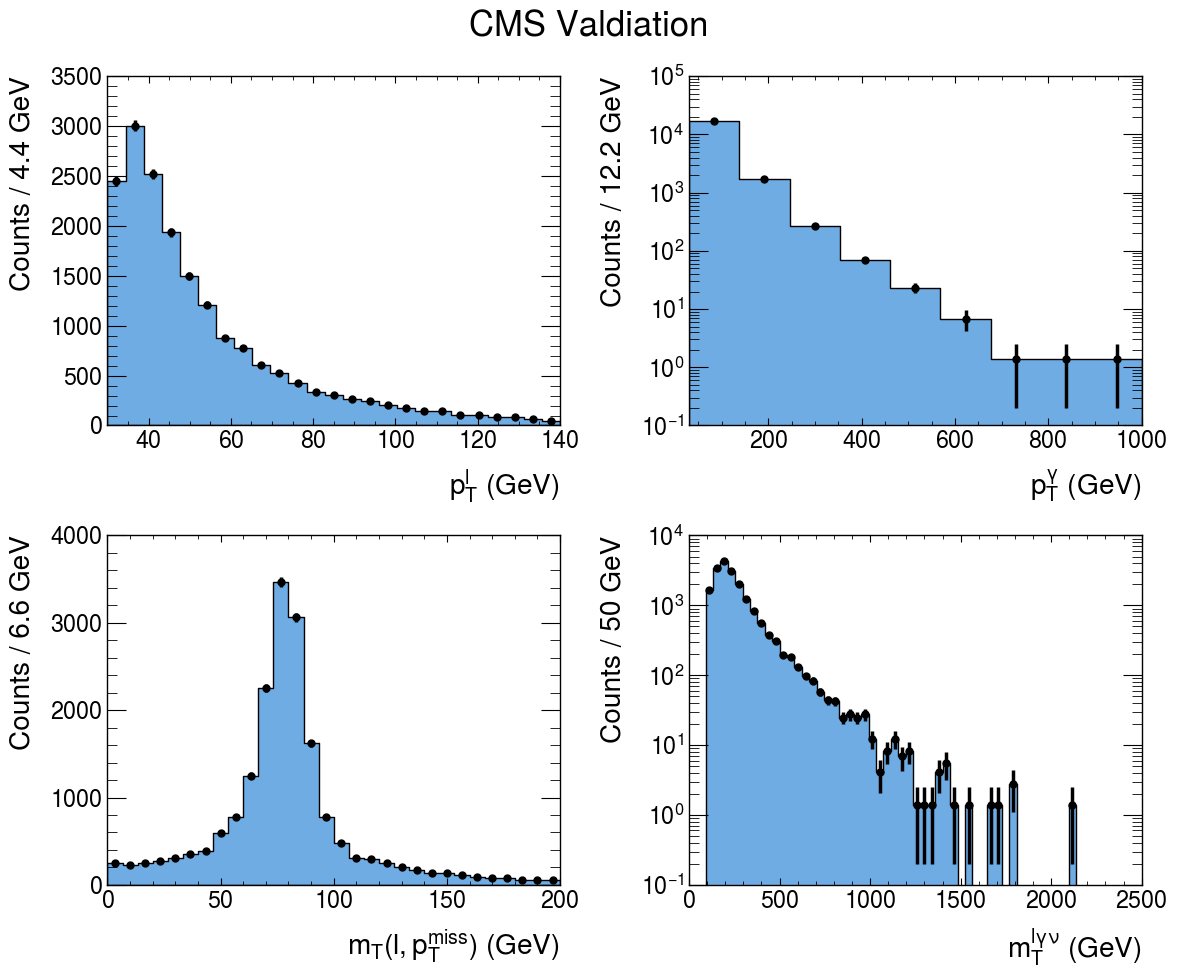

In [8]:
cross_section_inclusive=ufloat(0.9919,0.0016)
e=len(CMS_cut)/FILE_SIZE
epsilon=ufloat(   e, np.sqrt( e*(1-e)/FILE_SIZE  )  )

cross_section_integrated=cross_section_inclusive*epsilon *1000


fig,axes=plt.subplots(2,2,figsize=(12,10))


Pt_lepton=pd.concat([CMS_cut['Muon.PT'],CMS_cut['Electron.PT']],axis=0,ignore_index=True)
var=Pt_lepton
weight=pd.concat([CMS_cut['Event.Weight'],CMS_cut['Event.Weight']],axis=0,ignore_index=True)

counts, bins = np.histogram(var, 25,range=(30, 140),weights=W_CONSTANT*weight)
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
sns.histplot(x=var,bins=25,element='step',binrange=[30,140],edgecolor='black',ax=axes[0][0],weights=W_CONSTANT*weight)
axes[0][0].errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')

axes[0][0].set_xlim(30,140)
axes[0][0].set_ylabel('Counts / 4.4 GeV')
axes[0][0].set_xlabel(r'$\mathrm{p_{T}^{l}}$'+' (GeV)')




Pt_photon=CMS_cut['Photon.PT']
var=Pt_photon

counts, bins = np.histogram(var, 9,range=(30, 1000),weights=W_CONSTANT*CMS_cut['Event.Weight'])
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
sns.histplot(x=var,bins=9,element='step',edgecolor='black',binrange=[30,1000],ax=axes[0][1],weights=W_CONSTANT*CMS_cut['Event.Weight'])
axes[0][1].errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')
axes[0][1].set_yscale('log')
axes[0][1].set_ylabel('Counts / 12.2 GeV')
axes[0][1].set_xlabel(r'$\mathrm{p_{T}^{\gamma}}$'+' (GeV)')
axes[0][1].set_xlim(30,1000)






var=CMS_cut['Mt_lv']

counts, bins = np.histogram(var, 30,range=(0, 200),weights=W_CONSTANT*CMS_cut['Event.Weight'])
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
sns.histplot(x=var,bins=30,element='step',edgecolor='black',binrange=[0,200],ax=axes[1][0],weights=W_CONSTANT*CMS_cut['Event.Weight'])
axes[1][0].errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')
axes[1][0].set_ylabel('Counts / 6.6 GeV')
axes[1][0].set_xlabel(r'$\mathrm{m_{T}(l,p_{T}^{miss})}$'+' (GeV)')






var=CMS_cut['Mt_cluster']

counts, bins = np.histogram(var, 50,weights=W_CONSTANT*CMS_cut['Event.Weight'])
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
sns.histplot(x=var,bins=50,element='step',edgecolor='black',ax=axes[1][1],weights=W_CONSTANT*CMS_cut['Event.Weight'])
axes[1][1].errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')
axes[1][1].set_yscale('log')
axes[1][1].set_ylabel('Counts / 50 GeV')
axes[1][1].set_xlabel(r'$\mathrm{m_{T}^{l \gamma \nu}}$'+' (GeV)')

plt.suptitle('CMS Valdiation',size=25)


plt.tight_layout()
plt.show()



# Normalization

In [9]:
lumi=138
W_total=np.sum(events_df_full['Event.Weight'])
W_cut=np.sum(CMS_cut['Event.Weight'])
sigma=0.9957*1000

N_expected=lumi*W_cut*sigma/W_total

N_CMS=72798*0.53+109669*0.58
N_CMS/N_expected

5.438480184343321

# Eta v reconstruction

In [19]:

W_boson=particle.Particle.from_pdgid(24)
M_w=W_boson.mass/1000

CMS_cut['large_boost']=0.0
CMS_cut.loc[CMS_cut['Electron_size']==1,'large_boost']=M_w**2/(CMS_cut['Electron.PT']*CMS_cut['MissingET.MET'])
CMS_cut.loc[CMS_cut['Muon_size']==1,'large_boost']=M_w**2/(CMS_cut['Muon.PT']*CMS_cut['MissingET.MET'])

CMS_cut['delta']=0.0
CMS_cut.loc[CMS_cut['Electron_size']==1,'delta']=(M_w**2-CMS_cut['Mt_lv']**2)/(2*CMS_cut['Electron.PT']*CMS_cut['MissingET.MET'])
CMS_cut.loc[CMS_cut['Muon_size']==1,'delta']=(M_w**2-CMS_cut['Mt_lv']**2)/(2*CMS_cut['Muon.PT']*CMS_cut['MissingET.MET'])

In [26]:
np.random.seed(42)
CMS_cut['lepton_mass']=0.0
CMS_cut.loc[CMS_cut['Muon_size']==1,'lepton_mass']=particle.Particle.from_pdgid(13).mass/1000
CMS_cut.loc[CMS_cut['Electron_size']==1,'lepton_mass']=particle.Particle.from_pdgid(11).mass/1000
CMS_cut['Mt_lv']=0.0


CMS_cut.loc[CMS_cut['Electron_size']==1,'Mt_lv']=np.sqrt(  
    ( CMS_cut['MissingET.MET']+ np.sqrt((CMS_cut['Electron.PT'])**2+CMS_cut['lepton_mass']**2))**2 
    - (   CMS_cut['Electron.PT']*np.cos(CMS_cut['Electron.Phi']) +CMS_cut['MissingET.MET']*np.cos(CMS_cut['MissingET.Phi'])  )**2
        - (   CMS_cut['Electron.PT']*np.sin(CMS_cut['Electron.Phi']) +CMS_cut['MissingET.MET']*np.sin(CMS_cut['MissingET.Phi'])  )**2   )

CMS_cut.loc[CMS_cut['Muon_size']==1,'Mt_lv']=np.sqrt(  
    ( CMS_cut['MissingET.MET']+ np.sqrt((CMS_cut['Muon.PT'])**2+CMS_cut['lepton_mass']**2))**2 
    - (   CMS_cut['Muon.PT']*np.cos(CMS_cut['Muon.Phi']) +CMS_cut['MissingET.MET']*np.cos(CMS_cut['MissingET.Phi'])  )**2
        - (   CMS_cut['Muon.PT']*np.sin(CMS_cut['Muon.Phi']) +CMS_cut['MissingET.MET']*np.sin(CMS_cut['MissingET.Phi'])  )**2   )


CMS_cut['large_boost']=0.0
CMS_cut.loc[CMS_cut['Electron_size']==1,'large_boost']=M_w**2/(CMS_cut['Electron.PT']*CMS_cut['MissingET.MET'])
CMS_cut.loc[CMS_cut['Muon_size']==1,'large_boost']=M_w**2/(CMS_cut['Muon.PT']*CMS_cut['MissingET.MET'])

CMS_cut['delta']=0.0
CMS_cut.loc[CMS_cut['Electron_size']==1,'delta']=(M_w**2-CMS_cut['Mt_lv']**2)/(2*CMS_cut['Electron.PT']*CMS_cut['MissingET.MET'])
CMS_cut.loc[CMS_cut['Muon_size']==1,'delta']=(M_w**2-CMS_cut['Mt_lv']**2)/(2*CMS_cut['Muon.PT']*CMS_cut['MissingET.MET'])


CMS_cut['sign']=np.sign(CMS_cut['delta'])
CMS_cut.loc[(CMS_cut['sign']==-1.0) & (CMS_cut['Electron_size']==1),'Eta_v']=CMS_cut['Electron.Eta']
CMS_cut.loc[(CMS_cut['sign']==-1.0) & (CMS_cut['Muon_size']==1),'Eta_v']=CMS_cut['Muon.Eta']


def random_eta(row):
    eta_plus = row['Electron.Eta'] + np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
    eta_minus = row['Electron.Eta'] - np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
    return np.random.choice([eta_plus, eta_minus])
CMS_cut.loc[(CMS_cut['Electron_size'] == 1) & (CMS_cut['delta'] >= 0), 'Eta_v'] = CMS_cut[(CMS_cut['Electron_size'] == 1) & (CMS_cut['delta'] >= 0)].apply(random_eta, axis=1)


def random_eta(row):
    eta_plus = row['Muon.Eta'] + np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
    eta_minus = row['Muon.Eta'] - np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
    return np.random.choice([eta_plus, eta_minus])
CMS_cut.loc[(CMS_cut['Muon_size'] == 1) & (CMS_cut['delta'] >= 0), 'Eta_v'] = CMS_cut[(CMS_cut['Muon_size'] == 1) & (CMS_cut['delta'] >= 0)].apply(random_eta, axis=1)


# Phi reconstruction

In [27]:
def phi_transf(phi):
    return np.piecewise(
    phi,
    [
        phi < -np.pi / 2,  
        np.abs(phi) < np.pi / 2,  
        phi > np.pi / 2  
    ],
    [
        lambda phi: -(np.pi + phi),  
        lambda phi: phi,  
        lambda phi: np.pi - phi  
    ]
)

def phi_recon(charge,particle):

    p_l=vector.zip({'pt':CMS_cut[particle+'.PT'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)] ,'eta':CMS_cut[particle+'.Eta'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)],
                    'phi':CMS_cut[particle+'.Phi'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)],'mass':CMS_cut['lepton_mass'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)]  })
    p_y=vector.zip({'pt':CMS_cut['Photon.PT'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)] ,'eta':CMS_cut['Photon.Eta'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)],
                    'phi':CMS_cut['Photon.Phi'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)],'mass':0 })

    p_vl=vector.zip({'pt':CMS_cut['MissingET.MET'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)] ,'eta':CMS_cut['Eta_v'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)],
                'phi':CMS_cut['MissingET.Phi'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)],'mass':0 })


    p_w=p_l+p_vl
    p_com=p_w+p_y
    p_w_boosted=p_w.boost(-p_com.to_beta3())
    p_l_boosted=p_l.boost(-p_com.to_beta3())
    p_vl_boosted=p_vl.boost(-p_com.to_beta3())

    n1=p_w_boosted.to_Vector3D().cross(-p_com.to_Vector3D())    
    n1=n1/n1.mag

    n_ref=n1.cross(p_w_boosted.to_Vector3D())
    n_ref=n_ref/n_ref.mag
    if charge==1.0:
        n2=-p_l_boosted.to_Vector3D().cross(p_w_boosted.to_Vector3D())
    elif charge==-1.0:
        n2=-p_vl_boosted.to_Vector3D().cross(p_w_boosted.to_Vector3D())
    else: return 'error'

    n2=n2/n2.mag   

    x=n2.dot(n1)
    y=n2.dot(n_ref)

    phi=-np.arctan2(y,x)
    phi=np.array(phi)

    return phi_transf(phi)



CMS_cut['Phi']=0.0

CMS_cut.loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0),'phi']=phi_recon(1.0,'Electron')
CMS_cut.loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==-1.0),'phi']=phi_recon(-1.0,'Electron')

CMS_cut.loc[(CMS_cut['Muon_size']==1) & (CMS_cut['Muon.Charge']==1.0),'phi']=phi_recon(1.0,'Muon')
CMS_cut.loc[(CMS_cut['Muon_size']==1) & (CMS_cut['Muon.Charge']==-1.0),'phi']=phi_recon(-1.0,'Muon')

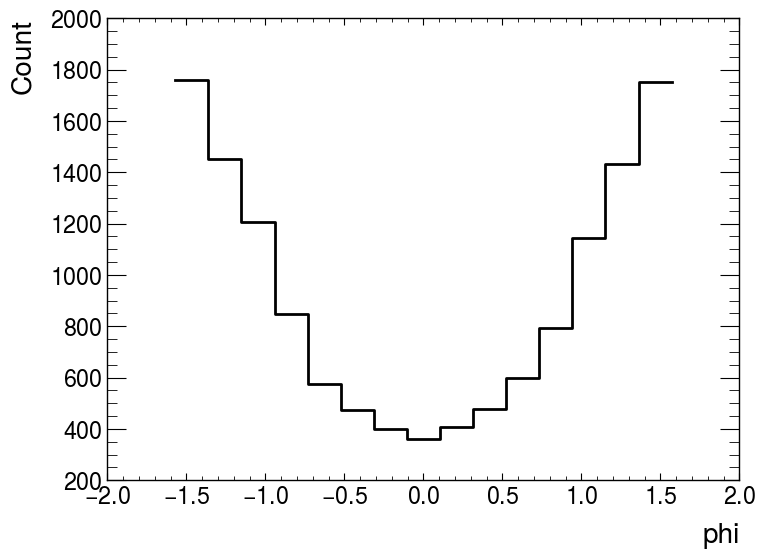

In [28]:
sns.histplot(CMS_cut['phi'],bins=15,element='step',fill=None,color='Black')
plt.show()

# Decay in Wy COM

In [29]:

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.offline as pyo

P_l=vector.zip({'pt':CMS_cut['Electron.PT'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)] ,'eta':CMS_cut['Electron.Eta'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)],
                'phi':CMS_cut['Electron.Phi'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)],'mass':CMS_cut['lepton_mass'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)]  })
P_y=vector.zip({'pt':CMS_cut['Photon.PT'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)] ,'eta':CMS_cut['Photon.Eta'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)],
                'phi':CMS_cut['Photon.Phi'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)],'mass':0 })

P_vl=vector.zip({'pt':CMS_cut['MissingET.MET'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)] ,'eta':CMS_cut['Eta_v'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)],
                'phi':CMS_cut['MissingET.Phi'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)],'mass':0 })


P_w=P_l+P_vl
P_com=P_w+P_y

P_w_boosted=P_w.boost(-P_com.to_beta3())
P_y_boosted=P_y.boost(-P_com.to_beta3())
P_l_boosted=P_l.boost(-P_com.to_beta3())
P_vl_boosted=P_vl.boost(-P_com.to_beta3())

n1=P_w_boosted.to_Vector3D().cross(-P_com.to_Vector3D())    
n1=n1/n1.mag

n_ref=n1.cross(P_w_boosted.to_Vector3D())
n_ref=n_ref/n_ref.mag

n2=-P_l_boosted.to_Vector3D().cross(P_w_boosted.to_Vector3D())
n2=n2/n2.mag


v = P_w_boosted.to_Vector3D()
v=v/v.mag
v=v[0]
v2=P_y_boosted.to_Vector3D()
v2=v2[0]
v2=v2/v2.mag


l=P_l_boosted.to_Vector3D()
l=l[0]
l=l/l.mag

vl=P_vl_boosted.to_Vector3D()
vl=vl[0]
vl=vl/vl.mag

r=P_com.to_Vector3D()

r=r[0]
r=r/r.mag

fig = go.Figure()

fig.add_trace(go.Scatter3d(x=[0, v.x], y=[0, v.y], z=[0, v.z],
                           mode='lines',
                           #marker=dict(size=5, color='green'),
                           line=dict(width=5, color='green'),name='w'))
fig.add_trace(go.Scatter3d(x=[0, v2.x], y=[0, v2.y], z=[0, v2.z],
                           mode='lines',
                           #marker=dict(size=5, color='yellow'),
                           line=dict(width=5, color='yellow'),name='y'))


fig.add_trace(go.Scatter3d(x=[0, n1[0].x], y=[0, n1[0].y], z=[0, n1[0].z],
                           mode='lines',
                           marker=dict(size=5, color='blue'),
                           line=dict(width=5, color='black'),name='n1'))



fig.add_trace(go.Scatter3d(x=[0, n_ref[0].x], y=[0, n_ref[0].y], z=[0, n_ref[0].z],
                           mode='lines',
                           #marker=dict(size=5, color='blue'),
                           line=dict(width=5, color='black'),name='n_ref'))

fig.add_trace(go.Scatter3d(x=[v.x,v.x+ l.x], y=[v.y, v.y+l.y], z=[v.z, v.z+l.z],
                           mode='lines',
                           
                           line=dict(width=5, color='blue'),name='electron'))

fig.add_trace(go.Scatter3d(x=[v.x, v.x+vl.x], y=[v.y, v.y+vl.y], z=[v.z,v.z+ vl.z],
                           mode='lines',
                          
                           line=dict(width=5, color='cyan'),name='muon'))

fig.add_trace(go.Scatter3d(x=[v.x,v.x+ n2[0].x], y=[v.y, v.y+n2[0].y], z=[v.z, v.z+n2[0].z],
                           mode='lines',
                           
                           line=dict(width=5, color='purple'),name='n2'))

#fig.add_trace(go.Scatter3d(x=[0, n2[0].x], y=[0, n2[0].y], z=[0, n2[0].z],
#                           mode='lines+markers',
#                           marker=dict(size=5, color='blue'),
#                           line=dict(width=5, color='purple'),name='n2'))

fig.add_trace(go.Scatter3d(x=[-r.x, r.x], y=[-r.y,r.y], z=[-r.z,r.z],
                           mode='lines',
                           
                           line=dict(width=6, color='red',dash='dot'),name='boost dir'))

u1 = np.linspace(-1, 1, 20)
v1 = np.linspace(-1, 1, 20)
U, V = np.meshgrid(u1, v1)

plane_x = U * v.x + V * r.x
plane_y = U * v.y + V * r.y
plane_z = U * v.z + V * r.z

plane_x_1 = v.x + U * l.x + V * vl.x
plane_y_1 = v.y + U * l.y + V * vl.y
plane_z_1 = v.z + U * l.z + V * vl.z



fig.add_trace(go.Surface(x=plane_x, y=plane_y, z=plane_z, opacity=0.4, colorscale=[[0, 'gray'], [1, 'gray']],showscale=False, name='plane1'))

fig.add_trace(go.Surface(x=plane_x_1, y=plane_y_1, z=plane_z_1, opacity=0.3, colorscale=[[0, 'blue'], [1, 'blue']],showscale=False, name='plane2'))




fig.add_trace(go.Cone(
    x=[v.x], y=[v.y], z=[v.z], 
    u=[v.x], v=[v.y], w=[v.z], 
    sizemode="absolute", sizeref=0.2, anchor="tip", colorscale=[[0, 'green'], [1, 'green']],
    showscale=False, name='w arrow'))

fig.add_trace(go.Cone(
    x=[v2.x], y=[v2.y], z=[v2.z], 
    u=[v2.x], v=[v2.y], w=[v2.z], 
    sizemode="absolute", sizeref=0.2, anchor="tip", colorscale=[[0, 'yellow'], [1, 'yellow']],
    showscale=False, name='y arrow'))

fig.add_trace(go.Cone(
    x=[v.x + l.x], y=[v.y + l.y], z=[v.z + l.z], 
    u=[l.x], v=[l.y], w=[l.z], 
    sizemode="absolute", sizeref=0.2, anchor="tip", colorscale=[[0, 'blue'], [1, 'blue']],
    showscale=False, name='electron arrow'))

fig.add_trace(go.Cone(
    x=[v.x + vl.x], y=[v.y + vl.y], z=[v.z + vl.z], 
    u=[vl.x], v=[vl.y], w=[vl.z], 
    sizemode="absolute", sizeref=0.2, anchor="tip", colorscale=[[0, 'cyan'], [1, 'cyan']],
    showscale=False, name='muon arrow'))


fig.update_layout(scene=dict(
    xaxis=dict(showbackground=False),  
    yaxis=dict(showbackground=False),  
    zaxis=dict(showbackground=False),  
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
))

pyo.plot(fig, filename='3d_vector_plot.html')

'3d_vector_plot.html'